Research question:
What is the forecast for airpoulltion in Kathmandy valley?

Type of analysis:
Predictive Analysis: How much airpollution can be expected to rise in upcoming years and when?

Possible stakeholders:
1.Health sector: Hospitals and clinics can anticipate surges in respiratory or cardiovascular cases during bad air days, and prepare resources.
2.Tourism Industry: Cleaner air initiatives can attract eco-tourists and improve Nepal’s image as a trekking/cultural destination.
3.Public : Can prepare for bad airdays based on predictions

KPIs to focus on:
1.Actionable Insights Generated
2.Health/Environmental Impact
3.Insight KPI 

Scope and limitations:
1.Focus Area
Study of air quality (e.g., PM2.5, PM10, NO₂) in Kathmandu Valley.

Prediction of air quality in the future.

2.Data Sources

Secondary datasets: Fill later

Hospital admission records or public health data (if accessible) : Fill later

Supplementary data: Fill later

3.Geographical Coverage
Kathmandu Metropolitan Area

4.Deliverables
Analytical report with insights.

Visualizations (graphs showing AQI vs. health trends).

Predictions

Recommendations for individuals, policymakers, or businesses.


Limitations:
1.Geographical Limitations

Restricted to Kathmandu Valley; results may not generalize to all of Nepal.

2.Accuracy

How accurate the predictions will be remains to be seen 


Data collection and aquisition
1.Dataset type : CSV format imported to SQL
2.Data source: Air quality index in Kathmandu US Diplomatic Post Phora Durbar by American Embassey (Open data Nepal)
3.Format : CSV

# Importing data

In [2]:
import pandas as pd
import numpy as np

In [54]:
import pyodbc as pyodbc
conn = pyodbc.connect('Driver={SQL Server};server=LAPTOP-7UQ473VF;DATABASE=AIRQUALITY;TRUSTED_CONNECTION=YES;')
df2 = pd.read_sql("SELECT * FROM AQTable", conn) 

C:\Users\USER\AppData\Local\Temp\ipykernel_24644\1042391439.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql("SELECT * FROM AQTable", conn)


# Basic EDA and data extraction

In [55]:
df2.head()

,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,o3,0.051,ppm,27.712463,85.315704
1,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T18:15:00+00:00,2021-03-13T00:00:00+05:45,pm25,69.000,┬╡g/m┬│,27.712463,85.315704
2,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,pm25,69.000,┬╡g/m┬│,27.712463,85.315704
3,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T17:15:00+00:00,2021-03-12T23:00:00+05:45,o3,0.030,ppm,27.712463,85.315704
4,3460,US Diplomatic Post: Phora Durbar Kathmandu,Kathmandu,NP,2021-03-12T16:15:00+00:00,2021-03-12T22:00:00+05:45,o3,0.030,ppm,27.712463,85.315704


In [56]:
df2.describe()

,locationId,value,latitude,longitude
count,61976.0,61976.000000,6.197600e+04,6.197600e+04
mean,3460.0,-13.381631,2.771246e+01,8.531570e+01
std,0.0,202.677872,1.065823e-14,2.842194e-14
min,3460.0,-999.000000,2.771246e+01,8.531570e+01
25%,3460.0,0.012000,2.771246e+01,8.531570e+01
50%,3460.0,0.060000,2.771246e+01,8.531570e+01
75%,3460.0,37.000000,2.771246e+01,8.531570e+01
max,3460.0,985.000000,2.771246e+01,8.531570e+01


In [57]:
df2.isna().sum()

locationId    0
location      0
city          0
country       0
utc           0
local         0
parameter     0
value         0
unit          0
latitude      0
longitude     0
dtype: int64

In [58]:
df2.duplicated().any()

np.False_

In [59]:
df2.isnull().sum()

locationId    0
location      0
city          0
country       0
utc           0
local         0
parameter     0
value         0
unit          0
latitude      0
longitude     0
dtype: int64

##### Data extraction:
Extracting only necessary columns from dataset here in this case pm25 values and timestamps

In [60]:
targetDF = df2[['local','parameter','value']].where(df2['parameter']=='pm25').dropna()

Using local(timestamps) as index and ensuring chronological order

In [61]:
targetDF['local'] = pd.to_datetime(targetDF['local'])

In [62]:
targetDF = targetDF.set_index('local').sort_index()

Plotting data to check for erronous data

In [63]:
import matplotlib.pyplot as plt

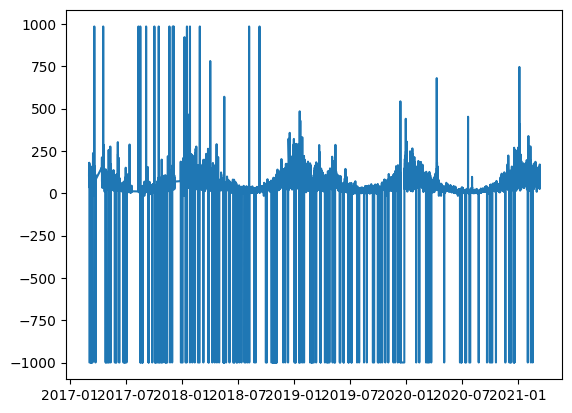

In [65]:
x = targetDF.index
y = targetDF['value']
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

Checking if the peaks are sensor error or practical data

In [66]:
anomalies = targetDF[targetDF['value']>500]


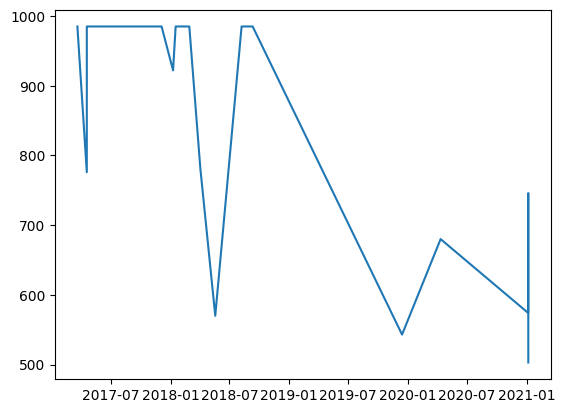

In [68]:
import matplotlib.pyplot as plt
x = anomalies.index
y = anomalies['value']
fig, ax = plt.subplots()
ax.plot(x, y)


#### Conclusions from basic EDA:
Below 0 values and above 500 values(spikes) are erronous data from sensors so needs to be cleaned

# Basic Data Cleaning

Replacing values less than 0 as NAN and interpolating

In [69]:
#condition = targetDF['value'] < 0 (Completely messes the time series so not used)
#targetDF2 = targetDF[~condition]
targetDF['value'] = targetDF['value'].mask(targetDF['value'] < 0, pd.NA)
targetDF['value'] = targetDF['value'].interpolate(method='linear',limit_direction='both')

Similarly removing values above 500 as NAN and interpolating them

<Axes: title={'center': 'Cleaned data'}, xlabel='local'>

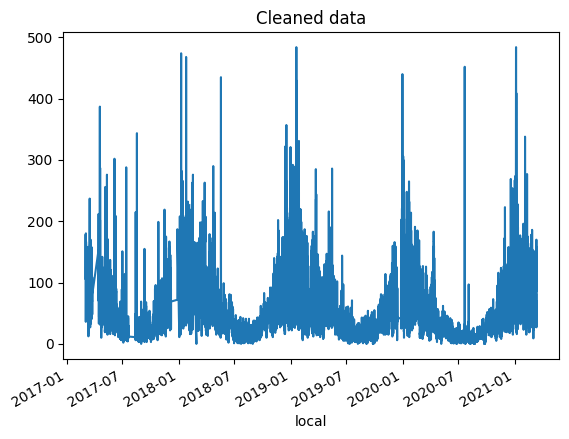

In [70]:
import numpy as np
targetDF.loc[targetDF['value']>500,'value'] = np.nan
targetDF['value'] = targetDF['value'].interpolate(method='linear', limit_direction='both')
targetDF['value'].plot(title='Cleaned data')


# Advanced EDA 

#### Seasonal, monthly and daily trend plots

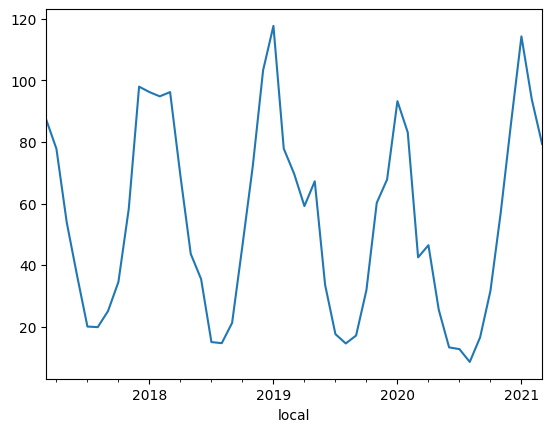

In [72]:
targetDF['value'].resample('ME').mean().plot()
plt.show()

For seasonal visualization extracting the sesason based on months value

In [74]:
def get_season(month) :
    if month in [3,4]:
        return 'spring'
    if month in [5,6]:
        return 'summer'
    if month in [7,8,9]:
        return 'monsoon'
    if month in [10,11]:
        return 'autumn'
    else:
        return 'winter'
targetDF['season'] = targetDF.index.month.map(get_season)     


<Axes: xlabel='month'>

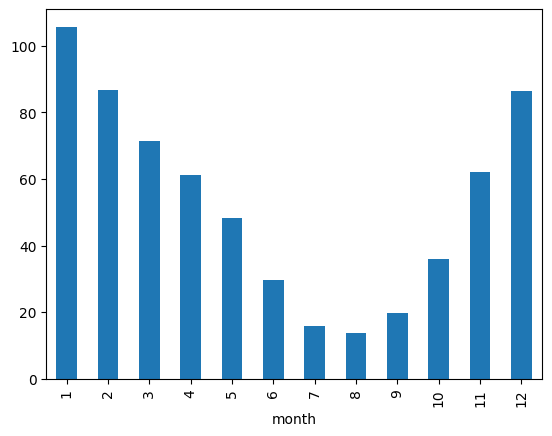

In [75]:
targetDF['month'] = targetDF.index.month
targetDF.groupby('month')['value'].mean().plot(kind='bar')

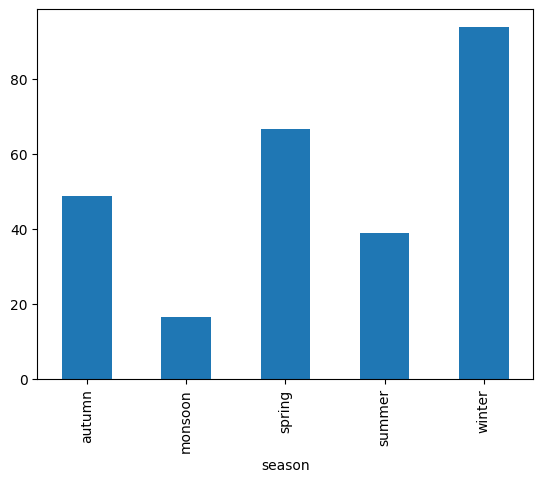

In [76]:
targetDF.groupby('season')['value'].mean().plot(kind='bar')
plt.show()

In [77]:
targetDF['hour'] = targetDF.index.hour

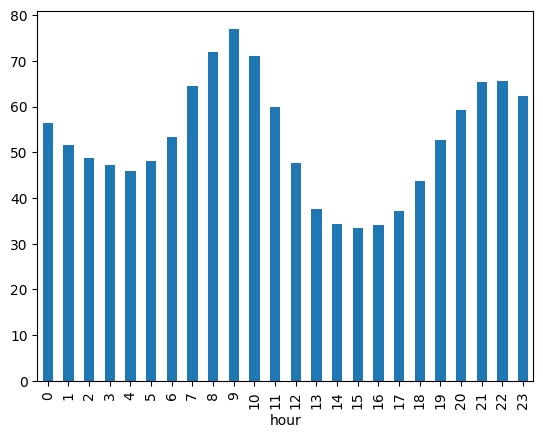

In [78]:
targetDF.groupby('hour')['value'].mean().plot(kind='bar')
plt.show()

In [79]:
from statsmodels.graphics.tsaplots import plot_acf

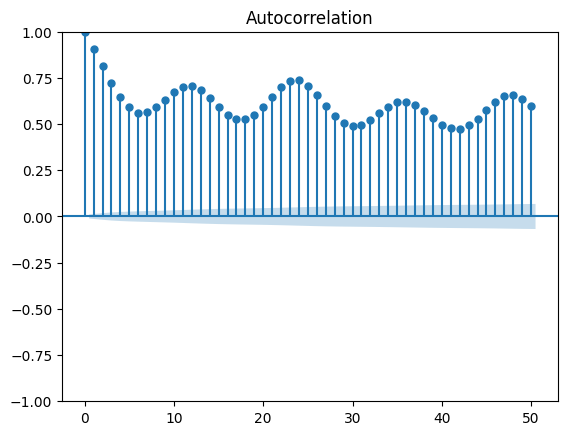

In [80]:
plot_acf(targetDF['value'], lags=50)   
plt.show()

#### Seasonal trend decomposition

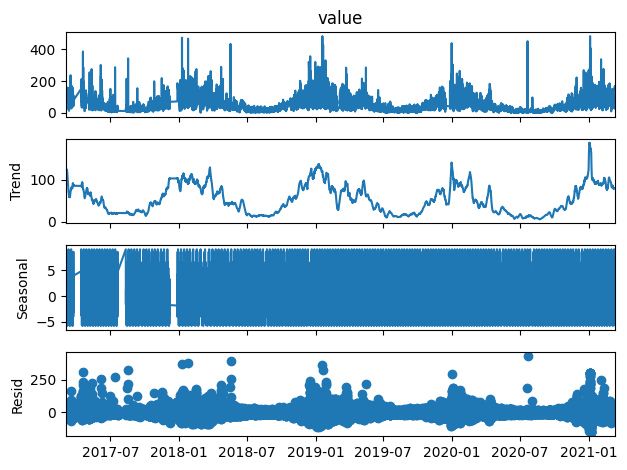

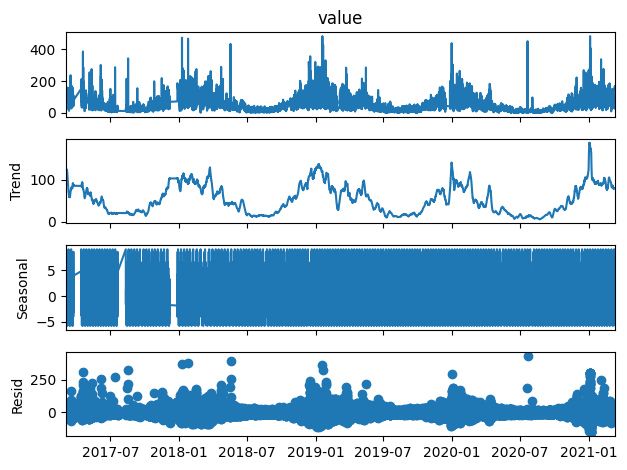

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(targetDF['value'], model='additive', period=168)
result.plot()

##### Conclusions from advanced EDA
1. Yearly seasonal trend : Pm25 value peaks during winter and is minimum during monsoon. The airpoulltion pm24 level is of the following order:
  winter>spring>summer>monsoon
2. Pollution level peaks in January wheres the pollution level is minimum in the month of July decreasing gradually and then increasing till december
3. Pollution pm25 level peaks during early office hours maybe due to increased traffic around 9:00 am then is minimum during the day as the sun heats the air and disperses pollutants.
4. During evening 5:00pm air starts cooling and thus pollution level starts increasing
5. Pm25 has clear daily and seasonal trends.

In [82]:
targetDF.to_csv('cleaned_Data.csv')

Checking stationarity means constant mean and varience. So checking it

In [ ]:
from  statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(targetDF2['value'])

ADF Statistic: -7.115133819736997
p-value: 3.848393293318664e-10
Stationary


This shows it is suitable for SARIMA model as it follows its requirement as it is stationary

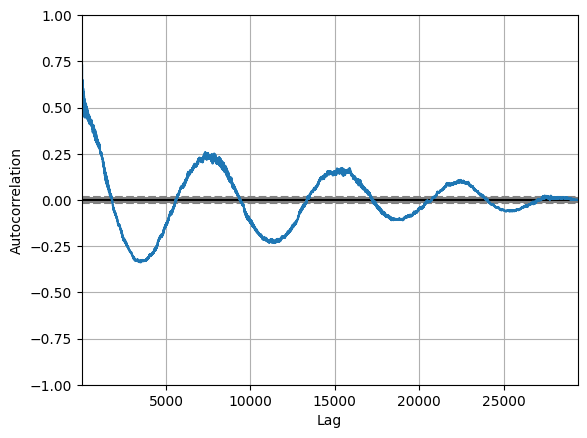

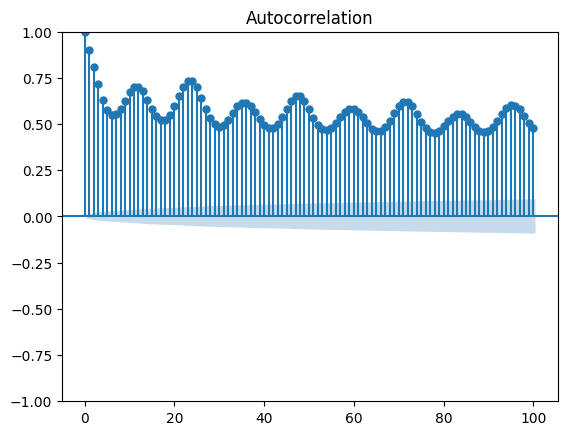

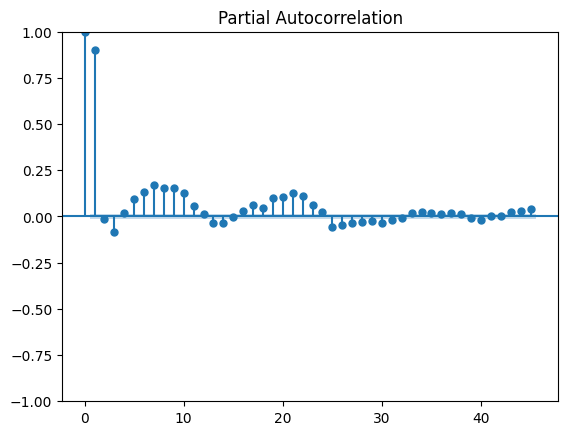

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(targetDF2['value'])
plot_acf(targetDF2['value'],lags=100)
plot_pacf(targetDF2['value'])
plt.show()

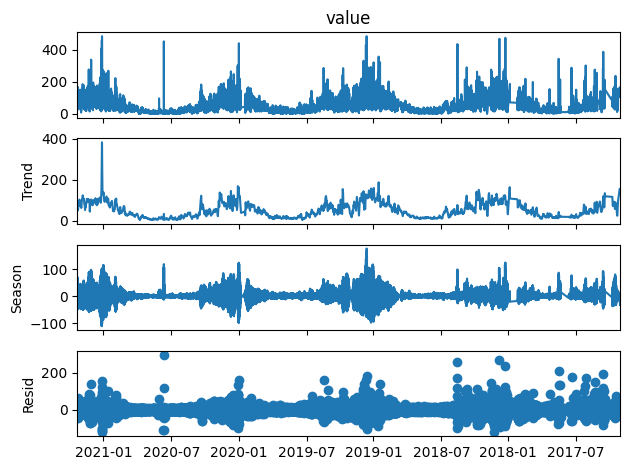

In [30]:

from statsmodels.tsa.seasonal import STL
stl = STL(targetDF[:-24]['value'],period=24)
res = stl.fit()
fig = res.plot()


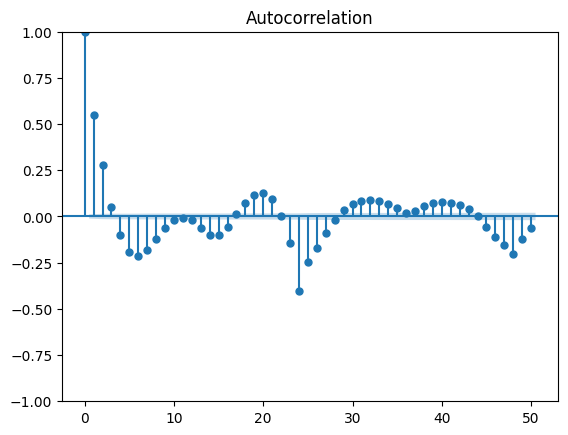

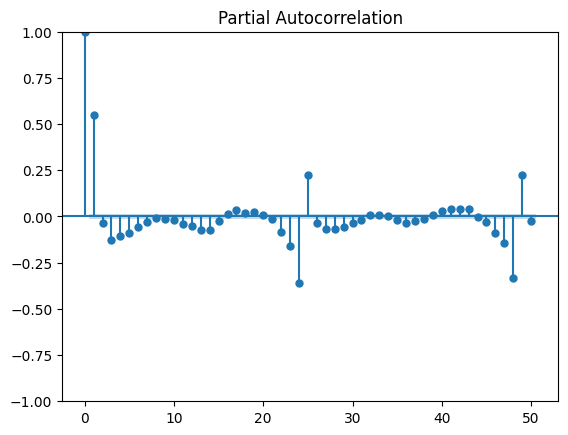

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(res.resid,lags=50)
plot_pacf(res.resid,lags=50)
plt.show()

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
residual = res.resid
season_length = 24
horizon = 24
df = pd.DataFrame({
    'unique_id': 'residuals',  
    'ds': res.resid.index,
    'y': res.resid.values
})
models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='h')
sf.fit(df=df)

StatsForecast(models=[AutoARIMA])

In [ ]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(5,0,1)(2,0,0)[24] with non-zero mean'

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
trend = res.trend
season_length = 24
horizon = 24
df = pd.DataFrame({
    'unique_id': 'trend',  
    'ds': res.trend.index,
    'y': res.trend.values
})
models = [AutoARIMA(season_length=season_length)]
sf2 = StatsForecast(models=models, freq='h')
sf2.fit(df=df)

StatsForecast(models=[AutoARIMA])

In [ ]:
arima_string(sf2.fitted_[0,0].model_)

'ARIMA(1,1,5)(0,0,1)[24]                   '

Performing ARIMA forecasting on residual remining after removal of seasonality and trend

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
residual = res.resid
residual = residual.asfreq('h')
residual.index = pd.DatetimeIndex(residual.index,freq='h')
arima_model = ARIMA(residual, order=(3, 0, 4),trend=None)
arima_fit = arima_model.fit()
print(arima_fit.summary())

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                35271
Model:                 ARIMA(3, 0, 4)   Log Likelihood             -115572.959
Date:                Wed, 15 Oct 2025   AIC                         231163.918
Time:                        12:25:39   BIC                         231240.155
Sample:                    03-04-2017   HQIC                        231188.193
                         - 03-13-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4910      0.157      3.127      0.002       0.183       0.799
ar.L1          2.1409      0.012    179.664      0.000       2.118       2.164
ar.L2         -1.7087      0.020    -83.780      0.0

Forecasting trend using ARIMA similar to residual

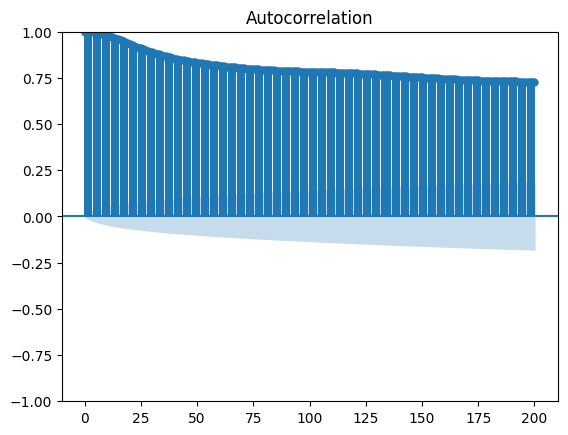

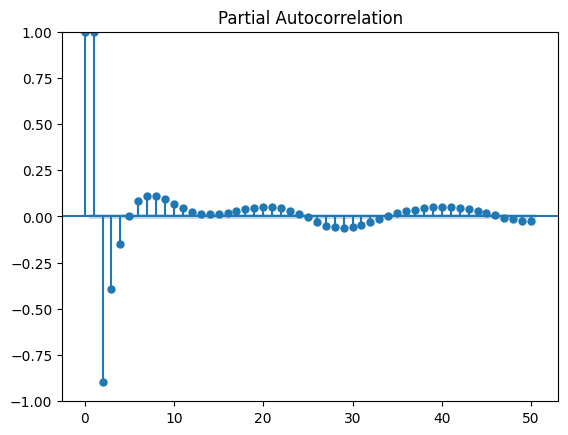

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(res.trend,lags=200)
plot_pacf(res.trend,lags=50)
plt.show()

In [ ]:
trend = res.trend
trend = trend.asfreq('h')


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(res.trend)
print('p-value:', result[1])

p-value: 1.52413746870471e-06


Since the trend is stationary we dont need differencing term for Arima ie (d)
As we can see from PACFabove, values drop sharply after lag 2 and ACF is gradually decreasing which suggests AR(2) structure. so p=2 and q=0 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(trend.values, order=(1,1,5),trend=None)
arima_fit_trend = arima_model.fit()
print(arima_fit_trend.summary())

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                29361
Model:                 ARIMA(1, 1, 5)   Log Likelihood               72484.931
Date:                Wed, 15 Oct 2025   AIC                        -144955.862
Time:                        13:04:32   BIC                        -144897.850
Sample:                             0   HQIC                       -144937.229
                              - 29361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9829      0.000   2602.831      0.000       0.982       0.984
ma.L1          1.3787      0.000   2902.421      0.000       1.378       1.380
ma.L2          1.5860      0.001   2038.086      0.0

In [ ]:
forecast_resid = arima_fit.forecast(steps=24)
forecast_trend = arima_fit_trend.forecast(steps=24)
future_seasonal = res.seasonal[-24:]
final_forecast = forecast_resid + forecast_trend + future_seasonal.values

Now performing predicion evaluation

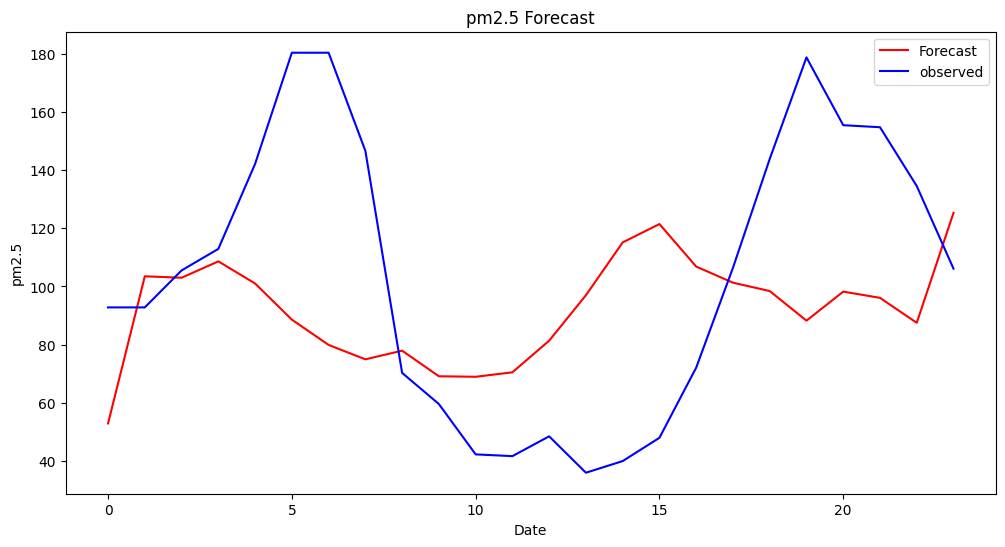

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(final_forecast.values, label='Forecast', color='red')
plt.plot(targetDF2[-24:]['value'].values, label='observed', color='blue')
plt.title("pm2.5 Forecast")
plt.xlabel("Date")
plt.ylabel("pm2.5")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(targetDF2[-24:]['value'].values, final_forecast)
mae

43.118873420768864

Since the sarimax model doesnot give reliable results we are moving to TCN deep learning model

Scaling the pm25 values for neural network

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

values = targetDF2['value'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)


In [ ]:
def create_sliding_window(data, window_size,forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

window_size =   168
forecast_horizon = 24 
X, y = create_sliding_window(scaled_values, window_size, forecast_horizon)

print("X shape:", X.shape)
print("y shape:", y.shape) 


X shape: (29193, 168, 1)
y shape: (29193, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv1D(filters=128, kernel_size=3, dilation_rate=1, padding='causal', activation='relu', input_shape=(window_size, 1)))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, dilation_rate=8, padding='causal', activation='relu'))
model.add(BatchNormalization())

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 62s 98ms/step - loss: 0.4590 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 2/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 56s 97ms/step - loss: 0.0091 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 53s 91ms/step - loss: 0.0061 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 4/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - loss: 0.0055 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 63s 108ms/step - loss: 0.0060 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 6/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 59s 101ms/step - loss: 0.0055 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 7/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 56s 95ms/step - loss: 0.0070 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 8/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - loss: 0.0055 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 9/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 55s 95ms/step - loss: 0.0049 - val_loss: 0.0031 - learning_rat

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {test_loss}')

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0058
Test Loss (MSE): 0.005838287528604269


In [ ]:
predictions = model.predict(X_test)

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


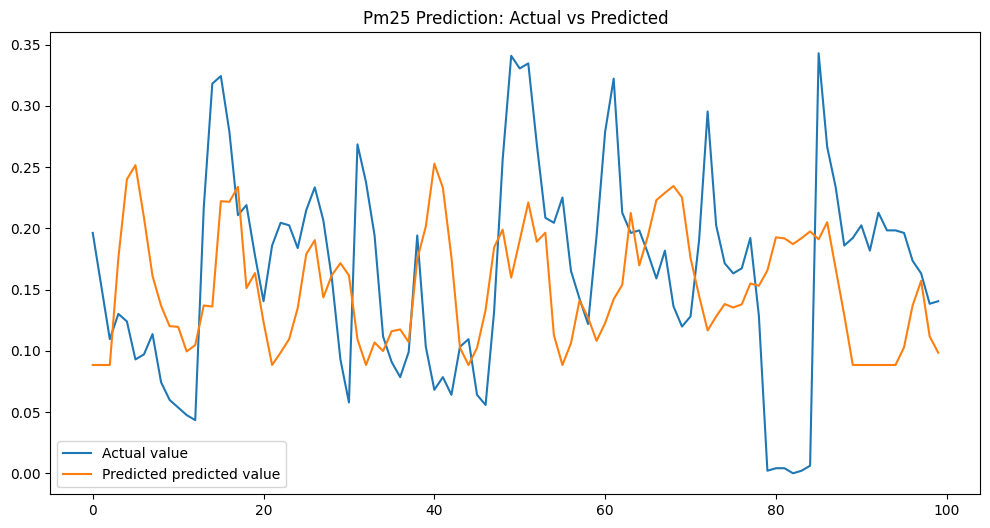

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual value")
plt.plot(predictions[:100], label="Predicted predicted value")
plt.title("Pm25 Prediction: Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test[:100], predictions[:100])
mae

0.0796607273012482

In [ ]:
y_test_scaled = y_test.reshape(-1, 1)
pred_scaled = predictions.reshape(-1, 1)
y_test_original = scaler.inverse_transform(y_test_scaled)
pred_original = scaler.inverse_transform(pred_scaled)

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_original = mean_absolute_error(y_test_original, pred_original)
print("MAE in original PM2.5 units:", mae_original)

MAE in original PM2.5 units: 23.73426538626271


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_original = mean_absolute_error(y_test_original[:100], pred_original[:100])
print("MAE in original PM2.5 units:", mae_original)

MAE in original PM2.5 units: 38.55579191843669


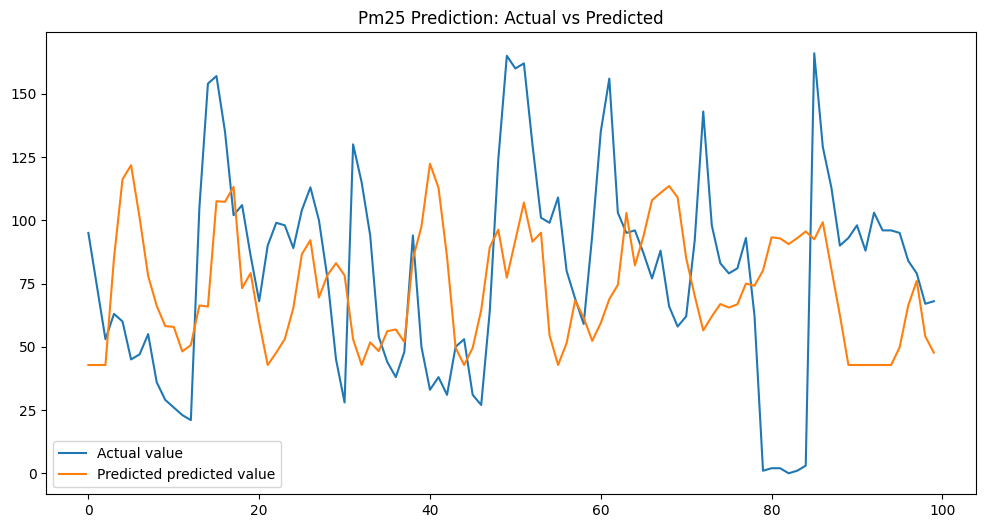

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:100], label="Actual value")
plt.plot(pred_original[:100], label="Predicted predicted value")
plt.title("Pm25 Prediction: Actual vs Predicted")
plt.legend()
plt.show()